## Part B

In [2]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm

import qiskit
from qiskit import assemble, transpile
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

import qiskit.ignis.verification.quantum_volume as qv

<ipython-input-2-a222b4e10082>:10: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  import qiskit.ignis.verification.quantum_volume as qv


### Generate QV sequences

In [117]:
qubit_lists = [[0, 1, 3], [0, 1, 3, 5], [0, 1, 3, 5, 7], [0, 1, 3, 5, 7, 10]]
ntrials = 100

qv_circs, qv_circs_nomeas = qv.qv_circuits(qubit_lists, ntrials)

qv_circs_nomeas[0] = qiskit.compiler.transpile(qv_circs_nomeas[0], basis_gates=['u1','u2','u3','cx'])

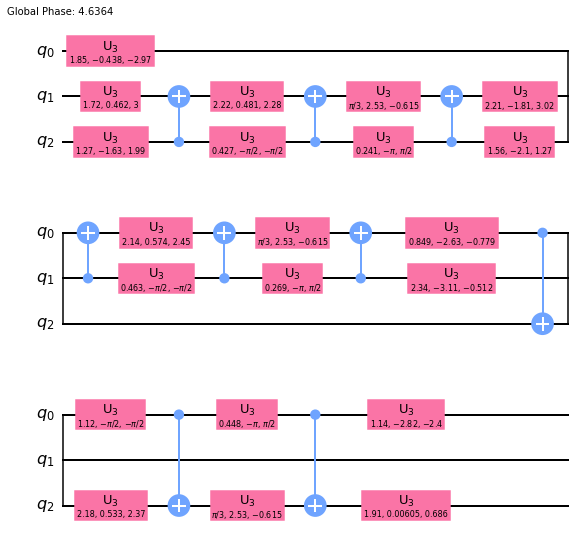

In [3]:
qv_circs_nomeas[0][0].draw(output='mpl', fold=11)

### Simulate the ideal QV circuits

In [118]:
sv_sim = qiskit.Aer.get_backend('aer_simulator')
ideal_results = []
for trial in tqdm(range(ntrials)):
    clear_output(wait=True)
    for qc in qv_circs_nomeas[trial]:
        qc.save_statevector()
    result = qiskit.execute(qv_circs_nomeas[trial], backend=sv_sim).result()
    ideal_results.append(result)

qv_fitter = qv.QVFitter(qubit_lists=qubit_lists)
qv_fitter.add_statevectors(ideal_results)

100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


### Calculate the heavy outputs

In [5]:
# Take trial 0 as example
for qubit_list in qubit_lists:
    l = len(qubit_list)
    print (f'qv_depth_{l}_trial_0 heavy outputs:', qv_fitter._heavy_outputs[f'qv_depth_{l}_trial_0'])
    print (f'qv_depth_{l}_trial_0 heavy output probability:', qv_fitter._heavy_output_prob_ideal[f'qv_depth_{l}_trial_0'])

qv_depth_3_trial_0 heavy outputs: ['011', '100', '101', '110']
qv_depth_3_trial_0 heavy output probability: 0.719990667984018
qv_depth_4_trial_0 heavy outputs: ['0001', '0100', '0101', '0111', '1001', '1010', '1011', '1110']
qv_depth_4_trial_0 heavy output probability: 0.8464101516960604
qv_depth_5_trial_0 heavy outputs: ['00000', '00001', '00010', '00110', '01000', '01001', '01010', '01011', '01101', '10000', '10010', '10101', '10110', '11000', '11001', '11101']
qv_depth_5_trial_0 heavy output probability: 0.848746733984747
qv_depth_6_trial_0 heavy outputs: ['000000', '000001', '000010', '000011', '000100', '000101', '001101', '001110', '010001', '010101', '010110', '010111', '011010', '011011', '011100', '100000', '100001', '100011', '100110', '101000', '101001', '101010', '110000', '110001', '110010', '110100', '110111', '111001', '111010', '111101', '111110', '111111']
qv_depth_6_trial_0 heavy output probability: 0.872145151075759


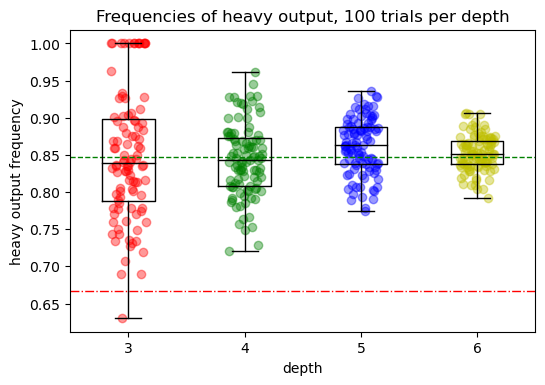

In [105]:
import numpy as np

width = 0.3

xs = [np.linspace(i+1 - width/2, i+1 + width/2, num=ntrials) for i in range(len(qubit_lists))]
depths = [len(qubit_list) for qubit_list in qubit_lists]
probs = [[qv_fitter._heavy_output_prob_ideal[f'qv_depth_{l}_trial_{trial}'] for trial in range(ntrials)] for l in depths]

plt.figure(dpi=100)
plt.boxplot(probs, labels=depths, medianprops=dict(color='black'))
palette = ['r', 'g', 'b', 'y']
for x, val, c in zip(xs, probs, palette):
    plt.scatter(x, val, alpha=0.4, color=c)
plt.hlines((1+np.log(2))/2, xmin=0.5, xmax=len(qubit_lists)+0.5, linestyle='--', linewidth=1, color='green')
plt.hlines(2/3, xmin=0.5, xmax=len(qubit_lists)+0.5, linestyle='-.', linewidth=1, color='red')
plt.title(f"Frequencies of heavy output, {ntrials} trials per depth")
plt.xlabel("depth")
plt.ylabel("heavy output frequency")
plt.show()

## Part C

### Define the noise model

In [7]:
noise_model = NoiseModel()
p1Q = 0.002
p2Q = 0.02
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

In [8]:
aer_sim = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1', 'u2', 'u3', 'cx']
shots = 1024
exp_results = []
for trial in tqdm(range(ntrials)):
    clear_output(wait=True)
    t_qcs = transpile(qv_circs[trial], basis_gates=basis_gates, optimization_level=3)
    qobj = assemble(t_qcs)
    result = aer_sim.run(qobj, noise_model=noise_model, max_parallel_experiments=0).result()
    exp_results.append(result)

100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


### Calculate the average gate fidelity

In [9]:
qv_fitter.add_data(exp_results)
for qubit_list in qubit_lists:
    l = len(qubit_list)
    print(f'qv_depth_{l}_trial_0:', qv_fitter._heavy_output_counts[f'qv_depth_{l}_trial_0'])

qv_depth_3_trial_0: 724
qv_depth_4_trial_0: 705
qv_depth_5_trial_0: 761
qv_depth_6_trial_0: 642


### Calculate the achievable depth

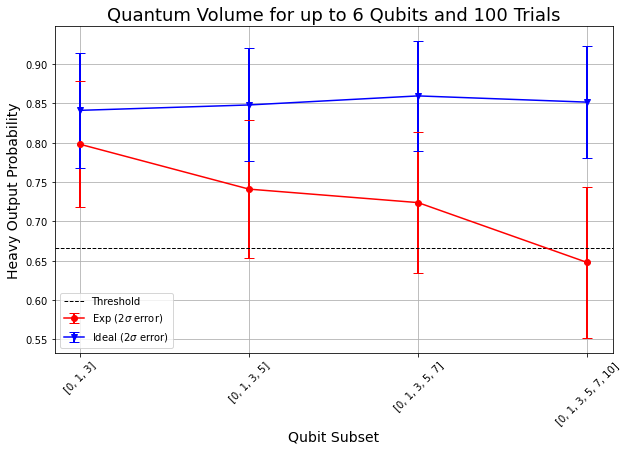

In [10]:
plt.figure(figsize=(10, 6))
ax = plt.gca()

qv_fitter.plot_qv_data(ax=ax, show_plt=False)

ax.set_title(f"Quantum Volume for up to {len(qubit_lists[-1])} Qubits and {ntrials} Trials", fontsize=18)

plt.show()

### Calculate the Quantum Volume

In [11]:
qv_success_list = qv_fitter.qv_success()
qv_list = qv_fitter.ydata
QV = 1
for qidx, qubit_list in enumerate(qubit_lists):
    if qv_list[0][qidx] > 2/3:
        if qv_success_list[qidx][0]:
            QV = qv_fitter.quantum_volume()[qidx]
            print(f"Width/depth {len(qubit_list)} greater than 2/3 ({qv_list[0][qidx]}) with confidence {qv_success_list[qidx][1]} (successful). Quantum volume {QV}")
        else:
            print(f"Width/depth {len(qubit_list)} greater than 2/3 ({qv_list[0][qidx]}) with confidence {qv_success_list[qidx][1]} (unsuccessful).")
    else:
        print(f"Width/depth {len(qubit_list)} less than 2/3 (unsuccessful).")

print(f"Quantum Volume is: {QV}")

Width/depth 3 greater than 2/3 (0.797998046875) with confidence 0.9994642926660069 (successful). Quantum volume 8
Width/depth 4 greater than 2/3 (0.7409765625) with confidence 0.9550751913028184 (unsuccessful).
Width/depth 5 greater than 2/3 (0.72384765625) with confidence 0.8995427447767406 (unsuccessful).
Width/depth 6 less than 2/3 (unsuccessful).
Quantum Volume is: 8


### Different noise models

In [119]:
def noisy_qv_exp(noise_model):
    aer_sim = qiskit.Aer.get_backend('aer_simulator')
    basis_gates = ['u1', 'u2', 'u3', 'cx']
    shots = 1024
    exp_results = []
    for trial in tqdm(range(ntrials)):
        clear_output(wait=True)
        t_qcs = transpile(qv_circs[trial], basis_gates=basis_gates, optimization_level=3)
        qobj = assemble(t_qcs)
        result = aer_sim.run(qobj, noise_model=noise_model, max_parallel_experiments=0).result()
        exp_results.append(result)
    
    qv_fitter = qv.QVFitter(qubit_lists=qubit_lists)
    qv_fitter.add_statevectors(ideal_results)
    qv_fitter.add_data(exp_results)
    # for qubit_list in qubit_lists:
    #     l = len(qubit_list)
    #     print(f'qv_depth_{l}_trial_0:', qv_fitter._heavy_output_counts[f'qv_depth_{l}_trial_0'])
    
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    qv_fitter.plot_qv_data(ax=ax, show_plt=False)
    ax.set_title(f"Quantum Volume for up to {len(qubit_lists[-1])} Qubits and {ntrials} Trials", fontsize=18)
    plt.show()

    qv_success_list = qv_fitter.qv_success()
    qv_list = qv_fitter.ydata
    QV = 1
    for qidx in range(len(qubit_lists)):
        if (qv_list[0][qidx] > 2/3) and qv_success_list[qidx][0]:
            QV = qv_fitter.quantum_volume()[qidx]
    
    return QV

100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


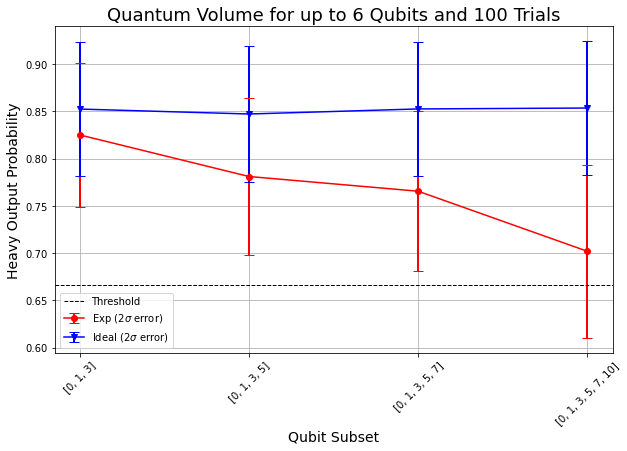

32


In [120]:
noise_model = NoiseModel()
p1Q = 0.002
p2Q = 0.01
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

qv1 = noisy_qv_exp(noise_model)
print(qv1)

100%|██████████| 100/100 [01:31<00:00,  1.10it/s]


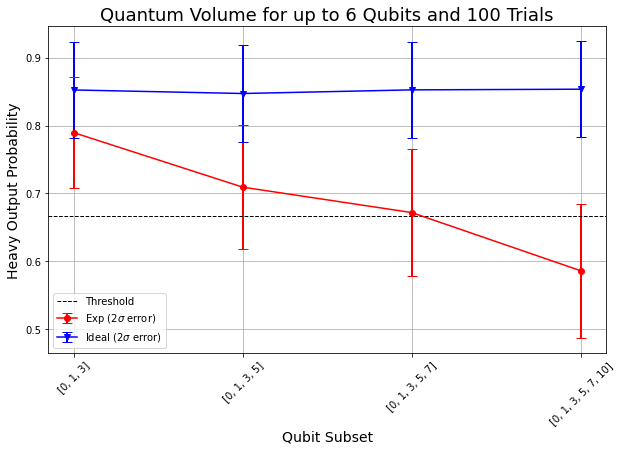

8


In [121]:
noise_model = NoiseModel()
p1Q = 0.01
p2Q = 0.01
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

qv2 = noisy_qv_exp(noise_model)
print(qv2)

100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


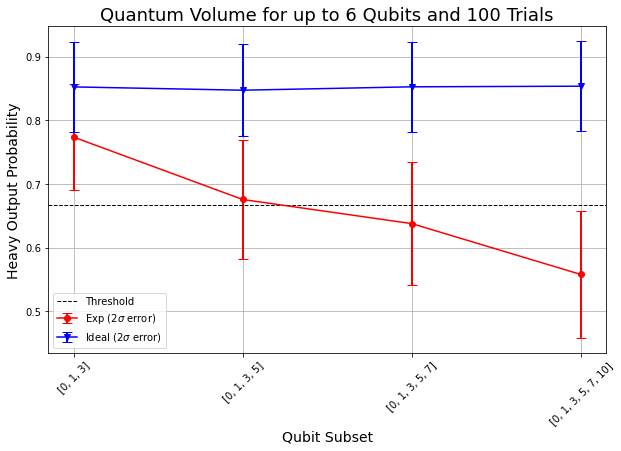

8


In [122]:
noise_model = NoiseModel()
p1Q = 0.002
p2Q = 0.05
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

qv3 = noisy_qv_exp(noise_model)
print(qv3)

100%|██████████| 250/250 [03:52<00:00,  1.08it/s]


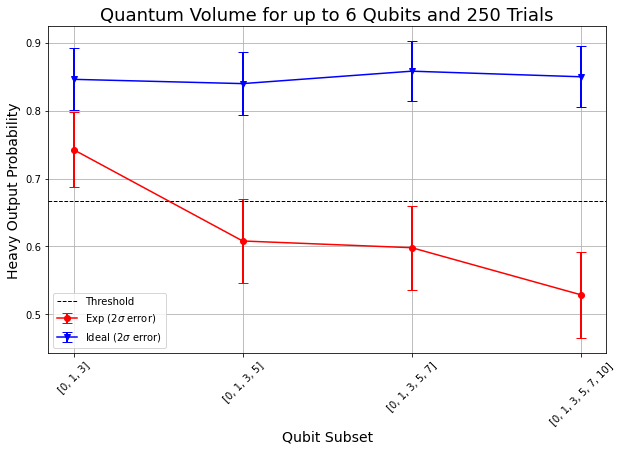

8


In [116]:
noise_model = NoiseModel()
p1Q = 0.01
p2Q = 0.05
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

qv4 = noisy_qv_exp(noise_model)
print(qv4)

### Real quantum hardware

In [4]:
from qiskit import IBMQ

provider = IBMQ.load_account()
backend = provider.get_backend('ibm_lagos')

In [5]:
qubit_lists = [[0, 1, 2], [0, 1, 2, 3], [0, 1, 2, 3, 5], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5, 6]]
ntrials = 100

qv_circs, qv_circs_nomeas = qv.qv_circuits(qubit_lists, ntrials)

In [6]:
sv_sim = qiskit.Aer.get_backend('aer_simulator')
ideal_results = []
for trial in tqdm(range(ntrials)):
    clear_output(wait=True)
    for qc in qv_circs_nomeas[trial]:
        qc.save_statevector()
    result = qiskit.execute(qv_circs_nomeas[trial], backend=sv_sim).result()
    ideal_results.append(result)

qv_fitter = qv.QVFitter(qubit_lists=qubit_lists)
qv_fitter.add_statevectors(ideal_results)

100%|██████████| 100/100 [00:02<00:00, 36.38it/s]


In [7]:
jobs = [qiskit.execute(qv_circs[trial], backend, optimization_level=3) for trial in tqdm(range(ntrials))]

100%|██████████| 100/100 [09:25<00:00,  5.66s/it]


In [10]:
real_results = []
for job in tqdm(jobs):
    result = job.result()
    real_results.append(result)

100%|██████████| 100/100 [05:29<00:00,  3.29s/it]


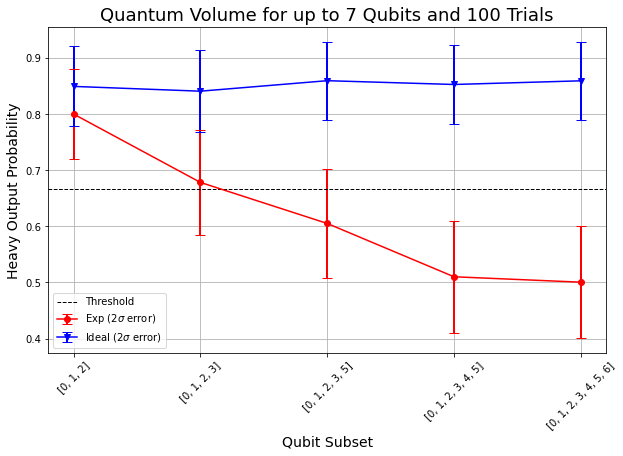

8


In [12]:
qv_fitter.add_data(real_results)
# for qubit_list in qubit_lists:
#     l = len(qubit_list)
#     print(f'qv_depth_{l}_trial_0:', qv_fitter._heavy_output_counts[f'qv_depth_{l}_trial_0'])

plt.figure(figsize=(10, 6))
ax = plt.gca()
qv_fitter.plot_qv_data(ax=ax, show_plt=False)
ax.set_title(f"Quantum Volume for up to {len(qubit_lists[-1])} Qubits and {ntrials} Trials", fontsize=18)
plt.show()

qv_success_list = qv_fitter.qv_success()
qv_list = qv_fitter.ydata
QV = 1
for qidx in range(len(qubit_lists)):
    if (qv_list[0][qidx] > 2/3) and qv_success_list[qidx][0]:
        QV = qv_fitter.quantum_volume()[qidx]
print(QV)

In [12]:
import qiskit.tools.jupyter
%qiskit_version_table